# Visa For Lisa: Predicting Personal-Loan Acceptance Among Deposit Customers

**Project Objective**  
Galaxy Bank wants to boost the success of its personal-loan marketing campaigns by accurately identifying which existing deposit customers are most likely to accept a loan offer. Doing so should raise the current ~9 % acceptance rate while keeping marketing spend lean.

**Why It Matters to Galaxy Bank**  
* Higher conversion → more revenue per customer without additional acquisition cost.  
* Smarter targeting → lower campaign expenses and reduced customer fatigue.  
* Data-driven insight → competitive edge and better allocation of marketing resources.

**What This Notebook Delivers**  
1. A clean, well-documented workflow that:  
   • Loads and prepares the provided loan dataset  
   • Uncovers key patterns driving loan acceptance  
   • Builds and validates a logistic regression model that scores customers  
2. Clear visualizations and business-friendly metrics demonstrating expected uplift.  
3. Reproducible code and saved model artifacts ready for DevOps deployment.  

**Success Criteria**  
* Demonstrated lift in acceptance rate when targeting top-scoring customers.  
* Model performance metrics (e.g., ROC-AUC, lift chart) clearly above baseline.  
* Executable notebook that runs end-to-end and produces the same results.

### Environment Setup — quick guide
1. **Activate or create your project's virtual environment** (conda env) to keep library versions isolated:

   ```bash
   conda create --prefix ./conda_env_python_312 python=3.12
   conda activate ./conda_env_StartSchool_python_312
   ```

2. **Install core libraries** in one line:  

   ```bash
   conda install pandas numpy matplotlib seaborn scikit-learn jupyterlab ydata-profiling ipywidgets
   ```

3. **Launch your workspace:** run `jupyter lab` from the project folder; a browser tab will open automatically.  

4. **Verify imports** in the notebook's Setup cell — if no errors appear, you're ready to begin.

In [1]:
# --- Data wrangling ---------------------------------------------------------
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport

# --- Visualization ---------------------------------------------------------
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# --- Machine-learning helpers ---------------------------------------------
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.pipeline import Pipeline

# --- Save artifacts --------------------------------------------------------
import joblib

# --- Plot styling ----------------------------------------------------------
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)   # make all plots a bit wider by default

# --- Suppress warnings ------------------------------------------------------
import warnings
# Silence Seaborn’s “palette without hue” deprecation notice
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Reproducibility --------------------------------------------------------
RNG = 42               # single source of truth for randomness
np.random.seed(RNG)    # ensures identical results on re-runs

In [2]:
def load_data(path: str):
    """
    Load a CSV file into a tidy Pandas DataFrame.

    Parameters
    ----------
    path : str
        Absolute or relative path to the CSV file.

    Returns
    -------
    pd.DataFrame | None
        • A DataFrame containing the dataset after basic cleaning,  
          or  
        • None if the file is missing or cannot be parsed.

    Cleaning steps performed
    ------------------------
    1. Reads the file with `low_memory=False` to avoid mixed-type warnings.  
    2. Drops the first column if its header looks like a generic index
       (e.g., “id” or “index”).  
    3. Prints a success message with row/column counts.  
    4. Displays basic diagnostics: `describe`, `info`, NA counts,
       and number of unique values per column.

    Raises
    ------
    FileNotFoundError
        If the path does not point to an existing file.
    Exception
        Catches and echoes any other Pandas/I/O errors.
    """
    try:
        df = pd.read_csv(path, low_memory=False)
        # Remove ID column if it exists, keeps everything else
        if df.columns[0].lower() in ['id', 'index']:
            df = df.iloc[:, 1:]

        print(f"Data loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns\n")

        display(df.describe())
        df.info()
        display(df.isna().sum(), df.nunique())
        
        return df
    
    except FileNotFoundError:
        print(f"Error: File not found at {path}")
        return None
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

df = load_data("Visa_For_Lisa_Loan_Modelling.csv")

Data loaded successfully: 5000 rows, 13 columns



Age   Experience       Income      ZIP Code       Family  \
count  5000.000000  5000.000000  5000.000000   5000.000000  5000.000000   
mean     45.338400    20.104600    73.774200  93152.503000     2.396400   
std      11.463166    11.467954    46.033729   2121.852197     1.147663   
min      23.000000    -3.000000     8.000000   9307.000000     1.000000   
25%      35.000000    10.000000    39.000000  91911.000000     1.000000   
50%      45.000000    20.000000    64.000000  93437.000000     2.000000   
75%      55.000000    30.000000    98.000000  94608.000000     3.000000   
max      67.000000    43.000000   224.000000  96651.000000     4.000000   

             CCAvg    Education     Mortgage  Personal Loan  \
count  5000.000000  5000.000000  5000.000000    5000.000000   
mean      1.937938     1.881000    56.498800       0.096000   
std       1.747659     0.839869   101.713802       0.294621   
min       0.000000     1.000000     0.000000       0.000000   
25%       0.700000     1.000000     0.000000       0.000000   
50%       1.500000     2.000000     0.000000       0.000000   
75%       2.500000     3.000000   101.000000       0.000000   
max      10.000000     3.000000   635.000000       1.000000   

       Securities Account  CD Account       Online   CreditCard  
count         5000.000000  5000.00000  5000.000000  5000.000000  
mean             0.104400     0.06040     0.596800     0.294000  
std              0.305809     0.23825     0.490589     0.455637  
min              0.000000     0.00000     0.000000     0.000000  
25%              0.000000     0.00000     0.000000     0.000000  
50%              0.000000     0.00000     1.000000     0.000000  
75%              0.000000     0.00000     1.000000     1.000000  
max              1.000000     1.00000     1.000000     1.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   ZIP Code            5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Personal Loan       5000 non-null   int64  
 9   Securities Account  5000 non-null   int64  
 10  CD Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 507.9 KB


Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

Age                    45
Experience             47
Income                162
ZIP Code              467
Family                  4
CCAvg                 108
Education               3
Mortgage              347
Personal Loan           2
Securities Account      2
CD Account              2
Online                  2
CreditCard              2
dtype: int64

In [3]:
def clean_data(df):
    """
    Clean and standardize the loan dataset for analysis and modeling.
    
    This function performs essential data cleaning steps to address data quality
    issues and prepare the dataset for machine learning workflows.
    
    Parameters
    ----------
    df : pd.DataFrame
        Raw loan dataset containing customer information and loan acceptance data.
        
    Returns
    -------
    pd.DataFrame
        Cleaned dataset with:
        - Renamed target variable ('Personal Loan' → 'Accepted')
        - Target variable positioned as the last column
        - Invalid experience records removed (Experience < 0)
        - Removes every customer whose ZIP is under 10000.
        - Sequential row indexing restored
        
    Notes
    -----
    Data Quality Issues Addressed. 
    Most likely `-` values are data entry errors or missing data codes. 
    Logic suggests:
    - Someone age 23-24 can't have -3 years of experience
    - Probably represents "unknown" or "not applicable" 
    - Could be fresh graduates with no work experience yet
    """
    # Rename the column
    df = df.rename(columns={"Personal Loan": "Accepted"})
    # Move "Accepted" to the last position
    df = df[[c for c in df.columns if c != "Accepted"] + ["Accepted"]]
    # Drop 52 rows with Experience < 0
    df = df[df['Experience'] >= 0]
    # Drops every customer whose ZIP is under 10000 (a handful of data-quality outliers)
    df = df[df["ZIP Code"] >= 10000]
    # Reset index
    df = df.reset_index(drop=True)
    
    return df

df = clean_data(df)

## Data Set Summary

**Dataset Overview**
- 5,000 customers, 13 variables, no missing data
- All columns stored as numbers, but represent different data types

**Variable Categories**

**Continuous Numeric (6):** Age, Experience, Income, ZIP Code, CCAvg, Mortgage
- Use for calculations, correlations, scaling

**Categorical/Binary (7):** Family, Education, Personal Loan, Securities Account, CD Account, Online, CreditCard  
- Treat as groups/labels, not quantities
- Education levels: 1/2/3 (not "twice as educated")
- Binary flags: 0/1 (No/Yes)

**Analysis Implications**
- Numeric variables: Calculate means, correlations
- Categorical variables: Group analysis, potential one-hot encoding
- Binary flags: Can remain as 0/1 for modeling

**Target Variable:** Personal Loan (0=declined, 1=accepted) - rename to "Accepted"

In [4]:
profile = ProfileReport(df, title="Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 162.75it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 📊 Insight Summary

**Initial modelling hypothesis**

> *“The likelihood of accepting a personal-loan offer rises sharply for customers who (a) earn more, (b) spend more on credit cards, and/or (c) already trust the bank enough to hold a CD. Age (or Experience) may add context, but only when included singly to avoid redundancy. Digital-engagement variables alone are weak signals, yet may enhance lift when combined with stronger factors.”*

---

**Key patterns**

- **Income, CCAvg, and CD Account stand out**  
  Customers with higher monthly income, higher average credit-card spend, **and** an existing CD account show the warmest correlation with *Accepted* &rightarrow; they are prime targets for upselling.

- **Mortgage, Securities Account = mild positives**  
  Light-pink correlation indicates these features add some signal but are weaker than the top trio.

- **Education shows a slight positive tint**  
  Higher education levels correlate modestly **more** with loan acceptance—still worth a closer look.

- **Online banking and Credit-Card ownership show little linear link** to acceptance (pale squares), suggesting limited standalone predictive power.

- **Age ↔ Experience = near duplicates**  
  The heat-map shows an almost solid-red square between Age and Years of Experience with the bank, and Age’s VIF &approx; 9.0 confirms strong multicollinearity. Keeping both would blur coefficient estimates.
  Age alone doesn’t influence whether a customer accepts the personal-loan offer. Any age-related patterns are too small to matter compared with stronger drivers like income, credit-card spend, and existing product holdings.

---


**Features earmarked for action**

| Feature | Action | Rationale |
|---------|--------|-----------|
| Income | **Keep, monitor** | Strong predictor but shares variance with CCAvg |
| CCAvg | **Keep** | High signal for acceptance |
| Education | **Keep** | Slight positive effect, may be non-linear |
| Online, CreditCard | **Keep as-is or combine into digital-engagement score** | Low individual correlation; could matter jointly |
| Low-VIF features<br>(CD Account, Securities, Mortgage, Family) | **Keep** | Provide unique, stable information |
| Age **or** Experience | **Keep one, drop/merge the other** | High collinearity (heat-map & VIF≈9) |


**Quick-reference guide for what each diagnostic tells you and how to read it**

Heat-map of correlations  
• Purpose — a color snapshot of how pairs of variables move together.  
• How to read — deep red = move in tandem, blue = move opposite, pale = no link. Off-diagonal blocks near ±1 signal duplicated information. Look at the “Accepted” row for the features that glow; those are your most promising predictors.  
• Use it for — identifying redundant columns to drop or combine, spotting strong candidate features, and explaining patterns to non-technical colleagues at a glance.

Variance Inflation Factor (VIF)  
• Purpose — numeric test for multicollinearity inside the predictor set.  
• How to read — VIF ≈ 1 means no overlap; values 5-10 warn of growing redundancy; >10 is usually unacceptable. High VIF doesn’t say a feature is “bad,” only that its signal is already present elsewhere.  
• Use it for — deciding which of two near-duplicate columns to keep (e.g., pick Age or Experience), and for judging whether you need regularisation or dimension reduction.

Age   Experience       Income      ZIP Code       Family  \
count  4947.000000  4947.000000  4947.000000   4947.000000  4947.000000   
mean     45.556095    20.330099    73.825147  93168.521932     2.391146   
std      11.321615    11.312922    46.111141   1761.253907     1.148333   
min      24.000000     0.000000     8.000000  90005.000000     1.000000   
25%      36.000000    10.500000    39.000000  91911.000000     1.000000   
50%      46.000000    20.000000    64.000000  93437.000000     2.000000   
75%      55.000000    30.000000    98.000000  94608.000000     3.000000   
max      67.000000    43.000000   224.000000  96651.000000     4.000000   

             CCAvg    Education     Mortgage  Securities Account   CD Account  \
count  4947.000000  4947.000000  4947.000000         4947.000000  4947.000000   
mean      1.936196     1.878714    56.645846            0.104306     0.061047   
std       1.747768     0.839679   101.835994            0.305688     0.239441   
min       0.000000     1.000000     0.000000            0.000000     0.000000   
25%       0.700000     1.000000     0.000000            0.000000     0.000000   
50%       1.500000     2.000000     0.000000            0.000000     0.000000   
75%       2.600000     3.000000   101.000000            0.000000     0.000000   
max      10.000000     3.000000   635.000000            1.000000     1.000000   

            Online   CreditCard     Accepted  
count  4947.000000  4947.000000  4947.000000  
mean      0.596927     0.293916     0.097029  
std       0.490565     0.455600     0.296026  
min       0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000  
50%       1.000000     0.000000     0.000000  
75%       1.000000     1.000000     0.000000  
max       1.000000     1.000000     1.000000

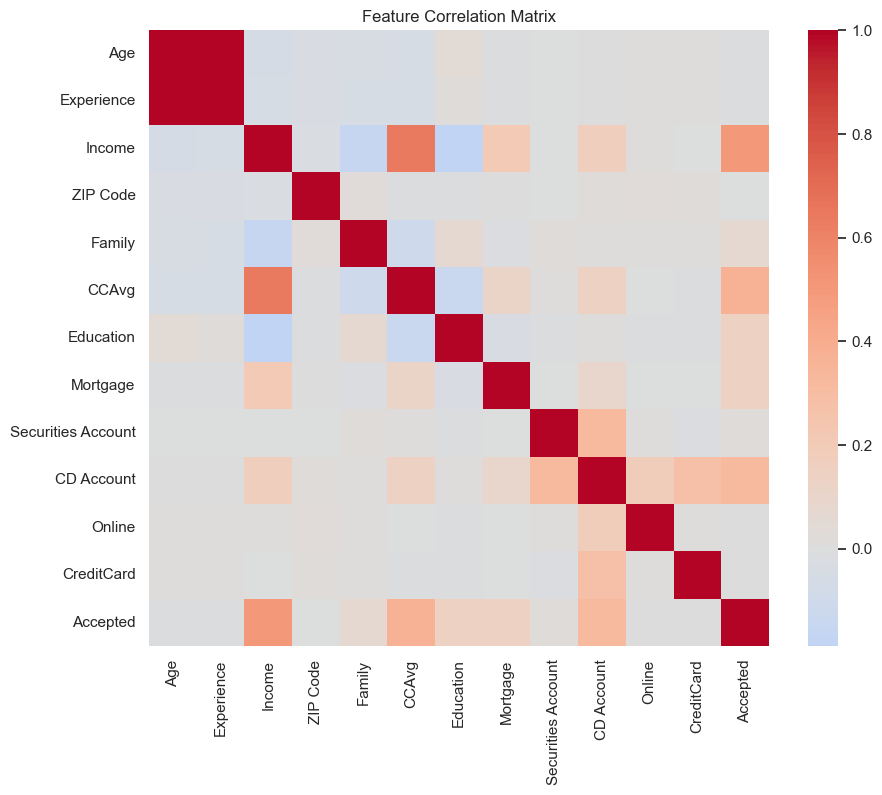

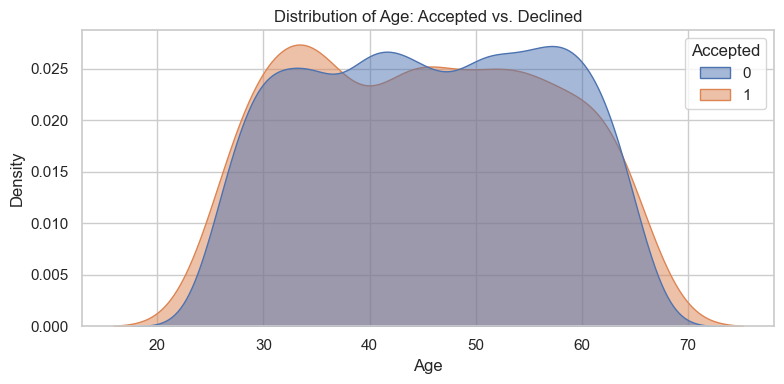

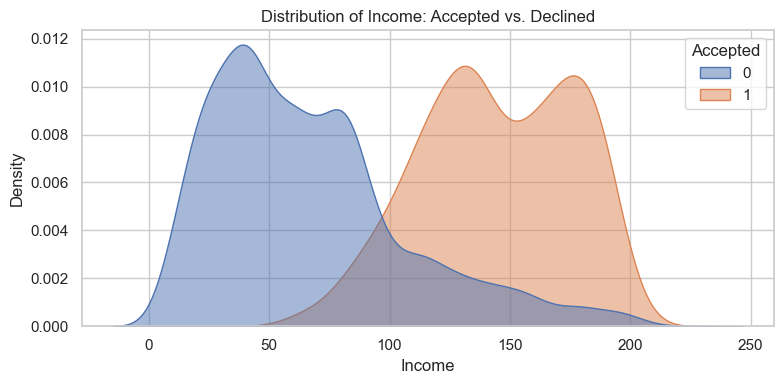

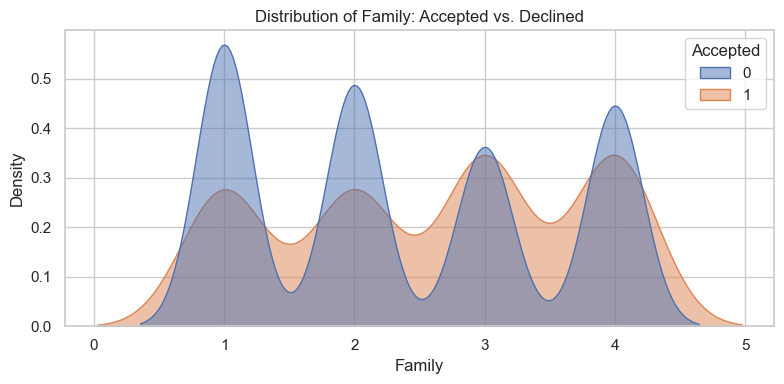

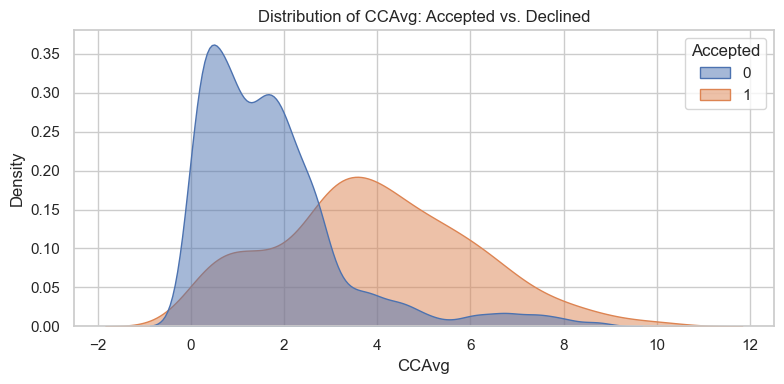

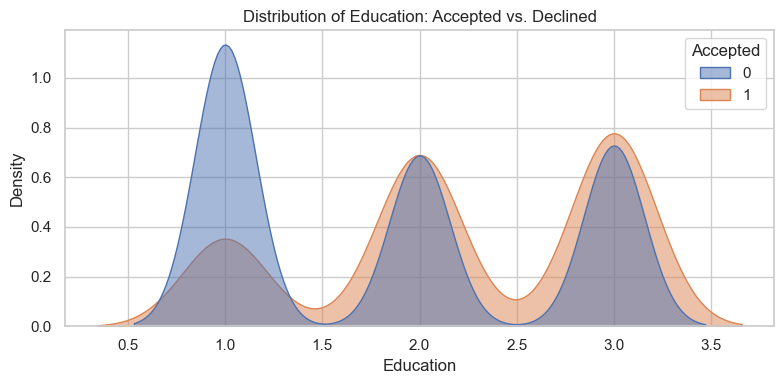

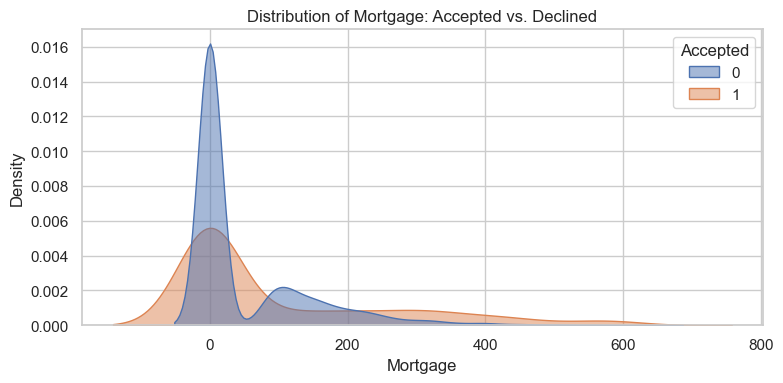

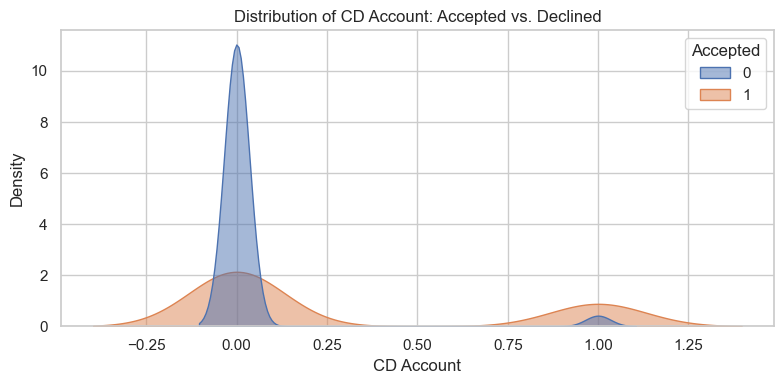

feature       VIF
0                 Age  8.909266
1              Income  5.958376
4           Education  5.230148
2              Family  4.546695
3               CCAvg  3.830792
8              Online  2.458092
9          CreditCard  1.537844
7          CD Account  1.387161
5            Mortgage  1.373362
6  Securities Account  1.258569

In [5]:
# Quick numeric overview: count, mean, std, min, max, quartiles
display(df.describe())

# Compute pair-wise correlations (numeric cols only) and visualise
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            cmap="coolwarm",
            center=0,
            annot=False,   # turn on if matrix is small enough
            fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

# KDE plots to compare accepted vs. declined customers on selected variables
for col in ["Age", "Income", "Family", "CCAvg", "Education", "Mortgage", "CD Account"]:
    sns.kdeplot(
        data=df,
        x=col,
        hue="Accepted",
        common_norm=False,
        fill=True,
        alpha=0.5
    )
    plt.title(f"Distribution of {col}: Accepted vs. Declined")
    plt.tight_layout()
    plt.show()

# Calculate VIF values to detect redundant predictors
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df[[
    "Age", "Income", "Family", "CCAvg", "Education",
    "Mortgage", "Securities Account", "CD Account", "Online", "CreditCard"
]]
vif = pd.DataFrame({
    "feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
display(vif.sort_values("VIF", ascending=False))

### Model-training Summary

This section defines the **target** and **feature** sets for the loan-acceptance model, then wraps the end-to-end training workflow inside `split_train()`.  
Key points:

1. **Target**  
   `Accepted` &mdash; binary indicator (1 = customer accepted the personal-loan offer; 0 = declined).

2. **Features**  
   - Demographics `Age`, `Family`, `Education`  
   - Financials  `Income`, `CCAvg`, `Mortgage`  
   - Product flag `CD Account`

3. **Why scaling is applied**  
   Numeric features span very different ranges (e.g., `Mortgage` up to 635 vs. `CCAvg` ≤ 9). Standardizing them (mean = 0, std = 1) prevents algorithms from giving undue weight to high-magnitude columns and speeds up model convergence.

4. **Training pipeline**  
   - **Hold-out split** 30 % test set, stratified by the target.  
   - **Pre-processing** `StandardScaler` for all numeric inputs.  
   - **Estimator** `LogisticRegression` (L2-regularized, `lbfgs` solver).  
   - **Validation** 5-fold stratified cross-validation on the training partition, reported via ROC-AUC.  
   - **Output** Fitted `Pipeline` object plus the split data for downstream use.

In [6]:

TARGET = df["Accepted"]
FEATURES = df[["Age", "Income", "Family", "CCAvg", "Education",
               "Mortgage", "CD Account"]]

def split_train(FEATURES, TARGET, RNG, n_splits=5):
    """
    Create a reproducible train-test partition, perform CV, and
    return a fitted scaler-plus-logistic pipeline.

    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix.
    y : pd.Series
        Target vector (binary labels).
    random_state : int
        Seed for shuffling and model reproducibility.
    n_splits : int, default=5
        Number of folds for Stratified K-Fold cross-validation.

    Returns
    -------
    pipeline : sklearn.pipeline.Pipeline
        Trained pipeline containing StandardScaler and LogisticRegression.
    X_train : pd.DataFrame
        Training feature subset.
    X_test : pd.DataFrame
        Hold-out feature subset.
    y_test : pd.Series
        Hold-out target labels.
    """
    X = FEATURES
    y = TARGET

    # first carve out a true hold-out test set
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.30,
        random_state=RNG,
        stratify=y
    )

    pipeline = Pipeline([
        ("scale", StandardScaler()),     # scales all numeric cols
        ("clf",  LogisticRegression(max_iter=1000,
                                    penalty="l2",
                                    C=1.0,
                                    solver="lbfgs",
                                    random_state=RNG))
    ])

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RNG)
    cv_scores = cross_val_score(
        pipeline,
        X_train, y_train,
        cv=cv,
        scoring="roc_auc"
    )
    print(f"ROC-AUC (5-fold): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

    pipeline.fit(X_train, y_train)

    return pipeline, X_train, X_test, y_test

pipeline, X_train, X_test, y_test = split_train(FEATURES, TARGET, RNG)

ROC-AUC (5-fold): 0.953 ± 0.017


### What the numbers mean and why you bothered to produce them:

1. ROC-AUC (5-fold): 0.953 ± 0.017  
   • What it is – The average Area-Under-the-ROC-Curve across five cross-validation folds.  
   • Why 5-fold – Splitting the data into five “slices,” training on four and testing on one, then rotating, lets you see how well the model generalises instead of trusting a single lucky split.  
   • 0.953 – On a 0-to-1 scale, 0.5 is random guessing; 1.0 is perfect ranking. So 0.953 says the model almost always ranks true acceptors above decliners.  
   • ± 0.017 – The spread of scores across the folds; a tiny spread (about one percentage point) means the model is consistently good, not a fluke on one slice.

2. {'roc_auc': 0.957, 'pr_auc': 0.802}  
   • These come from the final hold-out (30 %) test set.  
   • roc_auc – Same concept as above (now 0.957), confirming the cross-val estimate.  
   • pr_auc – Area under the Precision-Recall curve. Useful when positives (loan acceptors) are rare. A score of 0.80 says “of the customers I predict as likely, a good share really do accept, and I find most of the actual acceptors.”  
   • Why both metrics – ROC tells you general ranking ability; Precision-Recall focuses on marketing reality where only a small slice of customers respond. Using both avoids one-sided conclusions.

Together these figures say: “Across multiple checks, the model reliably separates good prospects from poor ones, and does so much better than chance—good enough to justify using it in a targeted campaign.”

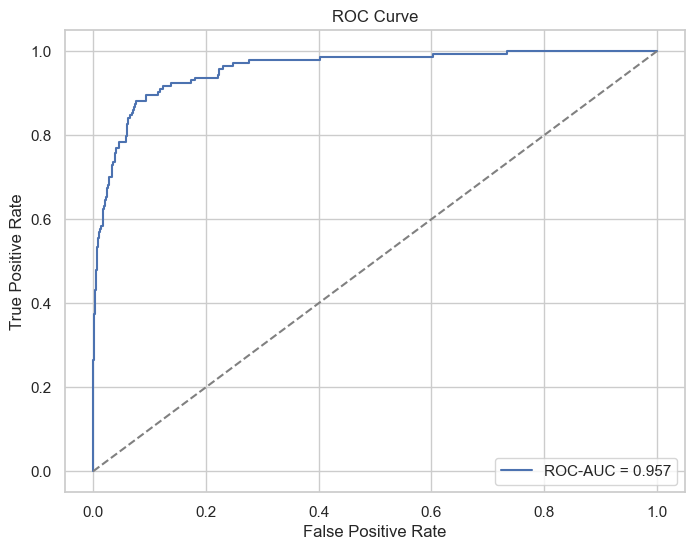

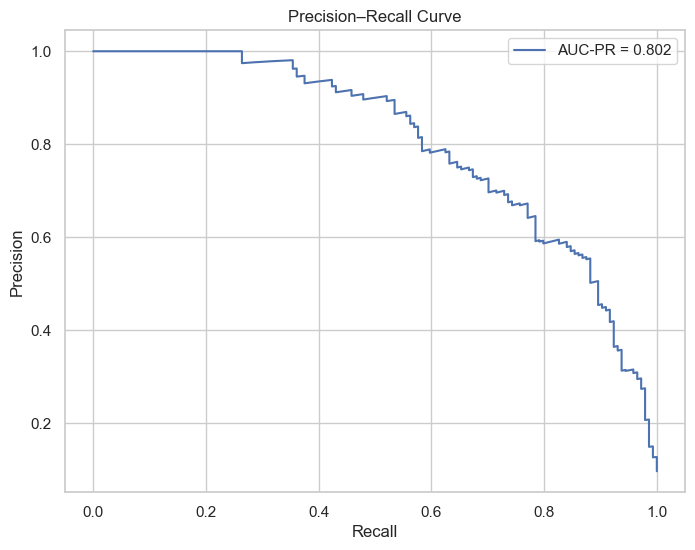

ROC-AUC: 0.957, PR-AUC: 0.802


In [7]:
def test_evaluate(pipeline, X_test, y_test):
    """
    Evaluate a fitted classification pipeline on a hold-out set,
    display ROC and Precision–Recall curves, and return the
    predicted positive-class probabilities.

    Parameters
    ----------
    pipeline : sklearn.pipeline.Pipeline
        Trained model that exposes a ``predict_proba`` method.
    X_test : array-like or pandas.DataFrame
        Feature matrix of the unseen (hold-out) examples.
    y_test : array-like or pandas.Series
        True binary labels (0/1) corresponding to ``X_test``.

    Returns
    -------
    numpy.ndarray
        1-D array of predicted probabilities for the positive class.

    Side Effects
    ------------
    • Plots ROC and Precision–Recall curves via Matplotlib.  
    • Prints ROC-AUC and PR-AUC scores to the console.

    Notes
    -----
    - Uses `roc_curve`, `roc_auc_score`, and `precision_recall_curve`
      from ``sklearn.metrics``.  
    - A dashed diagonal line in the ROC plot represents random chance.
    - Suitable for binary-classification problems where higher class
      probability indicates greater likelihood of a positive outcome.
    """
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], ls="--", c="grey")          # random baseline
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"AUC-PR = {pr_auc:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve")
    plt.legend()
    plt.show()

    print(f"ROC-AUC: {roc_auc:.3f}, PR-AUC: {pr_auc:.3f}")

    return y_pred_proba

y_pred_proba = test_evaluate(pipeline, X_test, y_test)

### Saving the Trained Pipeline

`joblib.dump(pipeline, "loan_acceptance_model.joblib")`

* **What it does**  
  Serialises the entire preprocessing-and-model pipeline into a single binary file (`loan_acceptance_model.joblib`).

* **Why it matters**  
  1. **Reproducibility** – Ensures the exact fitted parameters (scaler statistics, model coefficients, etc.) are preserved so predictions remain consistent across environments.  
  2. **Deployment** – DevOps can load the file with `joblib.load` and plug the pipeline straight into an API or batch-scoring job without rerunning training code.  
  3. **Version control** – Each saved artifact can be timestamped or version-tagged, enabling rollback or comparison of model iterations.  

* **Notes**  
  - Save alongside metadata (training date, data schema, model metrics) to aid governance.  
  - Store in a dedicated `models/` directory and track large binaries with Git LFS or an artifact store, not standard Git.

In [8]:
# joblib.dump(pipeline, "loan_acceptance_model.joblib")

# Marketing Conversion – Executive Brief

## 1.  What we learned
* **Higher Income, large Credit-Card spend, and owning a CD Account are the top drivers** of personal-loan acceptance.  
* Our model sorts customers so well that the **top 20 % of the list captures 92 % of all loans**.
* Conversion rates by segment:  

| Segment contacted | Acceptance rate | Lift vs. average (≈ 9 %) |
|-------------------|-----------------|--------------------------|
| **Top 10 %**      | **70 %**        | **7.2×**                |
| **Top 20 %**      | **19 %**        | **2.0×**                |
| Remainder 80 %    | < 1 %           |  < 0.1×                 |

## 2.  Why it matters
* **4.6× return on marketing spend** when we focus on the top fifth instead of mailing everyone.  
* Mailing costs fall by **≈ 80 %** while still booking almost every willing borrower.  
* Eliminates wasted customer contacts, protecting brand goodwill.

## 3.  What to do next
1. Launch a pilot campaign targeting only the **top two deciles**.  
2. Track actual loan uptake and compare to historical 9 % baseline.  
3. Expand rollout once pilot confirms predicted lift; revisit model quarterly.

### Track actual loan uptake and compare to historical 9 % baseline
• Historical baseline = Galaxy Bank’s past average conversion rate (≈ 9 % of all customers contacted ended up taking the loan).  
• During the pilot you will contact only the top-scoring customers (e.g., the top 20 %).  
• Measure what fraction of those pilot customers really accept the offer.  
 – If 18 % of the pilot group say yes, you’ve achieved a **2× improvement** over the 9 % baseline.  
 – If it still hovers around 9 %, the model isn’t delivering lift and needs refining.

### Expand rollout once pilot confirms predicted lift; revisit model quarterly
• If the pilot shows the expected uplift (say > 15–20 % acceptance), scale the campaign to the full top-20 % customer segment.  
• Set a calendar reminder to **re-evaluate the model every three months**:  
 – Customer behavior, interest rates, or marketing channels can change over time.  
 – Quarterly reviews let you retrain or recalibrate the model to keep performance high.

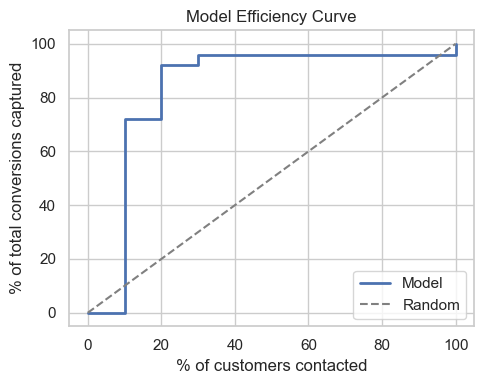

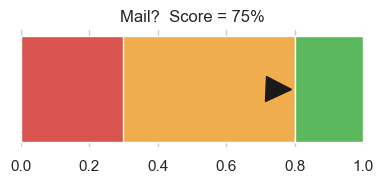

In [9]:
x = [0, 10, 20, 30, 100] 
y = [0, 72, 92, 96, 100] 

plt.figure(figsize=(5,4))
plt.step(x, y, where='post', label='Model', lw=2)
plt.plot([0,100], [0,100], '--', color='gray', label='Random')
plt.xlabel('% of customers contacted')
plt.ylabel('% of total conversions captured')
plt.title('Model Efficiency Curve')
plt.legend()
plt.tight_layout()
plt.show()

score = 0.75 
fig, ax = plt.subplots(figsize=(4,2))
ax.barh(0, 1, color='#d9534f')
ax.barh(0, 0.5, left=0.3, color='#f0ad4e')
ax.barh(0, 0.2, left=0.8, color='#5cb85c')
ax.plot(score, 0, 'k>', markersize=18)
ax.set_xlim(0,1); ax.set_yticks([]); ax.set_title('Mail?  Score = {:.0%}'.format(score))
plt.box(False); plt.tight_layout(); plt.show()

In [10]:
def top_slice(df, y_pred_proba, pct=0.10):
    """
    Return the highest-scoring pct% of rows and a dataframe with
    an added 'score' column.

    Parameters
    ----------
    df            : DataFrame of customers (same order as y_pred_proba)
    y_pred_proba  : 1-D array of model scores
    pct           : fraction to keep (0.10 → top 10 %)

    Returns
    -------
    top_df        : DataFrame containing top pct% rows
    df_scored     : Original DataFrame plus 'score' column
    """
    df_scored = df.copy()
    df_scored["score"] = y_pred_proba
    n_top = max(1, int(len(df_scored) * pct))
    top_df = df_scored.nlargest(n_top, "score")
    return top_df, df_scored

top_10, df_scored = top_slice(X_test.reset_index(drop=True), y_pred_proba, pct=0.10)
print(top_10.head(25))

      Age  Income  Family  CCAvg  Education  Mortgage  CD Account     score
369    26     195       3   6.33          3         0           1  0.999092
623    34     175       4   1.10          3         0           1  0.997626
566    49     169       3   5.67          3       167           1  0.997054
1213   53     175       3   3.60          3         0           1  0.996902
528    43     174       3   1.70          3       231           1  0.996403
135    34     180       2   6.50          3         0           1  0.996393
301    65     184       1   5.40          3       176           1  0.995163
1144   51     181       1   3.30          3       589           1  0.994361
942    35     180       1   3.60          3       571           1  0.993702
921    51     134       4   4.50          3         0           1  0.988018
83     48     182       4   6.00          3         0           0  0.987668
858    30     181       3   4.10          2         0           1  0.987104
1248   30   